# **Kiribati - DP3**

Instalamos dependencias necesarias para la ejecución del notebook.

In [1]:
pip install pmdarima

In [2]:
pip install yfinance

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from pmdarima import auto_arima
import datetime
import yfinance as yf
import seaborn as sns
from sklearn.metrics import r2_score

Función para calcular el indicador técnico de la media móvil exponencial

In [4]:
def EMA(df, n):
    EMA = pd.Series(df.ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA


Proceso de obtención de valores desde API de yahoo finance

In [5]:
media_mov_short = 33

BTRAW = yf.download("BTC-USD",start="2017-01-01", end="2021-05-6")
GSPCRAW = yf.download("^GSPC",start="2017-01-01", end="2021-05-6")

BTRAW.reset_index(inplace = True)
GSPCRAW.reset_index(inplace = True)

BTRAW = BTRAW.add_prefix('BT_')
GSPCRAW = GSPCRAW.add_prefix('GSPC_')

Dataset = pd.merge(left=BTRAW, right=GSPCRAW, how='left', left_on='BT_Date', right_on='GSPC_Date')
Dataset.drop(['GSPC_Date'], axis=1, inplace=True)
Dataset.drop(['BT_Open', 'BT_High', 'BT_Low', 'BT_Adj Close'], axis=1, inplace=True)
Dataset.drop(['GSPC_Open', 'GSPC_Volume','GSPC_High', 'GSPC_Low', 'GSPC_Adj Close'], axis=1, inplace=True)
Dataset.rename(columns={"BT_Date":"Date"},inplace=True)
Dataset['BT_Real'] = Dataset['BT_Close']
#Transform
Dataset['EMA'] = EMA(Dataset['BT_Close'], media_mov_short)
Dataset['MA'] = Dataset['BT_Close'].rolling(window=media_mov_short).mean()
Dataset.fillna( method ='ffill', inplace = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
Dataset.dropna(inplace=True)
corr = Dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

,BT_Close,BT_Volume,GSPC_Close,BT_Real,EMA,MA
BT_Close,1.000000,0.726695,0.822202,1.000000,0.989211,0.985288
BT_Volume,0.726695,1.000000,0.757330,0.726695,0.708964,0.701552
GSPC_Close,0.822202,0.757330,1.000000,0.822202,0.818277,0.814472
BT_Real,1.000000,0.726695,0.822202,1.000000,0.989211,0.985288
EMA,0.989211,0.708964,0.818277,0.989211,1.000000,0.999246
MA,0.985288,0.701552,0.814472,0.985288,0.999246,1.000000


Preparamos las funciones necesarias para entrar con fb-prophet.

In [7]:
def fit_model(df):
    m = Prophet(daily_seasonality=True)
    m.fit(df)
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)
    return m, forecast, future

def fit_model_not_stational(df):
    m = Prophet(daily_seasonality=False)
    m.fit(df)
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)
    return m, forecast, future

def fb_plots(m, fore):
    return plot_plotly(m, fore)

In [8]:
dataset_bt = Dataset[['Date','BT_Close']]
dataset_bt.columns = ["ds","y"]
model_bt, forecast_bt, future_bt = fit_model_not_stational(dataset_bt)

dataset_bt_v = Dataset[['Date','BT_Volume']]
dataset_bt_v.columns = ["ds","y"]
model_bt_v, forecast_bt_v, future_bt_v = fit_model_not_stational(dataset_bt_v)

dataset_gspc = Dataset[['Date','GSPC_Close']]
dataset_gspc.columns = ["ds","y"]
model_gspc, forecast_gspc, future_gspc = fit_model(dataset_gspc)

Ploteamos el resultado de predicción del Bitcoin

In [9]:
fb_plots(model_bt, forecast_bt)

Ploteamos el resultado de predicción del Bitcoin volume

In [10]:
fb_plots(model_bt_v, forecast_bt_v)

Ploteamos el resultado de predicción del valor de Standard & Poors

In [11]:
fb_plots(model_gspc, forecast_gspc)

Creamos la actualización con los valores predecidos.

In [12]:
d = {'Date':forecast_bt.ds[-30:],'BT_Close': forecast_bt.trend[-30:],'BT_Volume':forecast_bt_v.yhat[-30:],'GSPC_Close': forecast_gspc.yhat[-30:]}
df_predicted = pd.DataFrame(data=d)
frames = [Dataset, df_predicted]
df_full = pd.concat(frames)
df_full.reset_index(inplace = True)
df_full.drop(['index'], axis=1, inplace=True)
df_full['EMA'] = EMA(df_full['BT_Close'], media_mov_short)
df_full['MA'] = df_full['BT_Close'].rolling(window=media_mov_short).mean()
df_full_bt_real = df_full.copy()
df_full.drop(['BT_Real'], axis=1, inplace=True)
df_full.dropna(inplace=True)
df_full.head()

,Date,BT_Close,BT_Volume,GSPC_Close,EMA,MA
32,2017-03-06,1272.829956,153656992.0,2375.310059,1150.060442,1100.167266
33,2017-03-07,1223.540039,291256000.0,2368.389893,1155.013245,1106.583631
34,2017-03-08,1150.000000,332603008.0,2362.979980,1154.678208,1110.222721
35,2017-03-09,1188.489990,212283008.0,2364.870117,1156.919913,1114.634538
36,2017-03-10,1116.719971,563795968.0,2372.600098,1154.274454,1117.343023


Arima

In [13]:
exogenous_features = ["BT_Volume","GSPC_Close","EMA","MA"]
df_full['year'] = df_full['Date'].map(lambda x: x.year)
df_full_bt_real['year'] = df_full_bt_real['Date'].map(lambda x: x.year)
df_full['month'] = df_full['Date'].map(lambda x: x.month)

df_full_train = df_full[df_full.year  < 2020]
df_full_valid = df_full[df_full.year >= 2020]
df_full_bt_real = df_full_bt_real[df_full_bt_real.year >= 2020]

model = auto_arima(df_full_train.BT_Close, exogenous=df_full_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_full_train.BT_Close, exogenous=df_full_train[exogenous_features])

forecast = model.predict(n_periods=len(df_full_valid), exogenous=df_full_valid[exogenous_features])
df_full_valid["Forecast_ARIMAX"] = forecast
df_full_bt_real["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=14954.697, Time=2.98 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16891.715, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14954.487, Time=1.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=16429.731, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=23013.428, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=14955.093, Time=2.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=14954.993, Time=2.16 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning:

divide by zero encountered in reciprocal

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=20667.284, Time=1.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14952.542, Time=0.93 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=14953.167, Time=1.92 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14953.071, Time=1.89 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16428.623, Time=0.71 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning:

divide by zero encountered in reciprocal

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(2,0,1)(0,0,0)[0]             : AIC=20665.412, Time=0.93 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 17.416 seconds


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
df_full_valid_calc_r2 = df_full_bt_real[:-30]
r2_score = r2_score(df_full_valid_calc_r2.BT_Real , df_full_valid_calc_r2.Forecast_ARIMAX)
number_valid = df_full_valid.shape[0]
number_train = df_full_train.shape[0]

Ploteamos el grafico de los valores, del bitcoin. La linea verde representa el punto en el que gastamos los datos para validación del modelo y el calculo de las metricas.

RMSE of Auto ARIMAX: 2843.994278737377
MAE of Auto ARIMAX: 1655.3380706316336
R2 in production: 0.9723545814502843
Number of elements in train:  1031 Number of elements in validacion: 518


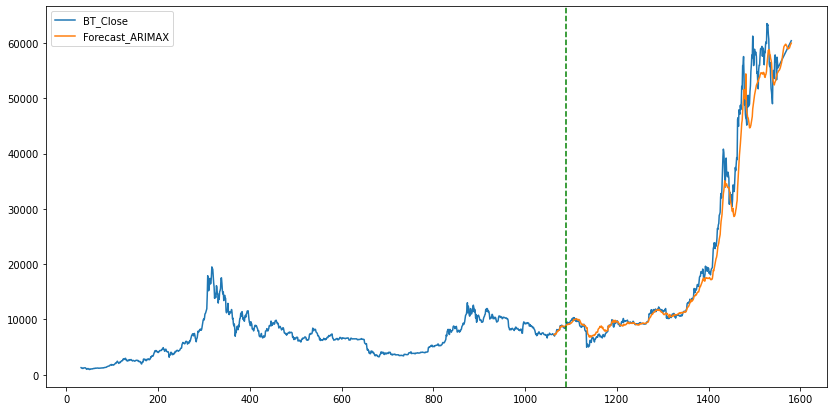

In [15]:
frames = [df_full_train, df_full_valid]
df_full_rew = pd.concat(frames)
df_full_rew[["BT_Close", "Forecast_ARIMAX"]].plot(figsize=(14, 7)).axvline(1088, color="green", linestyle="dashed")

print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_full_valid.BT_Close, df_full_valid.Forecast_ARIMAX)))
print("MAE of Auto ARIMAX:", mean_absolute_error(df_full_valid.BT_Close, df_full_valid.Forecast_ARIMAX))
print("R2 in production:", r2_score)
print("Number of elements in train: ", number_train, "Number of elements in validacion:", number_valid)

Representación del Forecast respecto al valor real


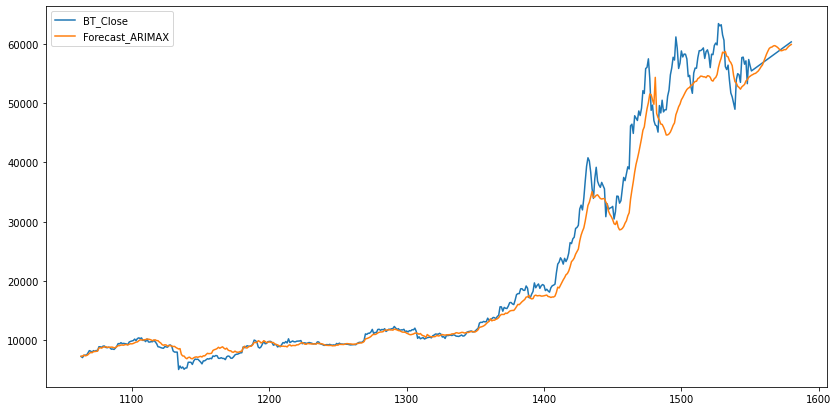

In [16]:
df_full_valid[["BT_Close", "Forecast_ARIMAX"]].plot(figsize=(14, 7))
print("Representación del Forecast respecto al valor real")

Guardamos los datos, que contienen también la predicción para gastarlos en la web app, que tiene el dashboard.

In [17]:
df_full_valid.to_csv('prediccion_30d.csv')